In [45]:
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from SgdAnn import SgdAnn

In [46]:
def load_data(directory_path="./data"):
    inputs = []
    outputs = []
    outputNames = ["normal", "sepia"]

    for filename in os.listdir(directory_path):
        is_sepia = 1 if filename.startswith("sepia_") else 0
        img_path = os.path.join(directory_path, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize((64, 64))

            img_array = np.array(img)
            r_mean = np.mean(img_array[:, :, 0])
            g_mean = np.mean(img_array[:, :, 1])
            b_mean = np.mean(img_array[:, :, 2])

            rb_ratio = r_mean / b_mean

            features = [r_mean, g_mean, b_mean, rb_ratio]

            inputs.append(features)
            outputs.append(is_sepia)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(inputs), np.array(outputs), outputNames

In [47]:
inputs, outputs, outputNames = load_data()
print("Feature names: ['avg_red', 'avg_green', 'avg_blue', 'red_blue_ratio']")

Feature names: ['avg_red', 'avg_green', 'avg_blue', 'red_blue_ratio']


In [48]:
def splitData(inputs, outputs):
    np.random.seed(42)
    trainInputs, testInputs, trainOutputs, testOutputs = train_test_split(
        inputs, outputs, test_size=0.2, random_state=42, stratify=outputs
    )

    return trainInputs, trainOutputs, testInputs, testOutputs

In [49]:
def normalisation(trainData, testData):
    scaler = StandardScaler()
    normalizedTrainData = scaler.fit_transform(trainData)
    normalizedTestData = scaler.transform(testData)

    return normalizedTrainData, normalizedTestData

Training set class distribution: [224 224]


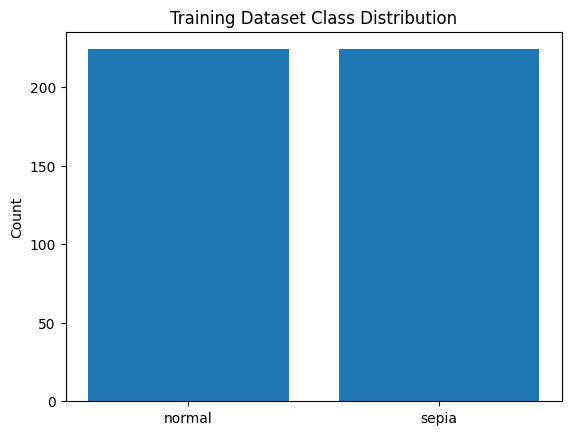

In [50]:
trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)
trainInputsNorm, testInputsNorm = normalisation(trainInputs, testInputs)

print(f"Training set class distribution: {np.bincount(trainOutputs)}")
bins = range(len(outputNames) + 1)
plt.hist(trainOutputs, bins=bins, rwidth=0.8)
bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
plt.xticks(np.arange(min(bins) + bin_w / 2, max(bins), bin_w), outputNames)
plt.title("Training Dataset Class Distribution")
plt.ylabel("Count")
plt.show()


In [51]:
clf = SgdAnn(
    hidden_layer_sizes=(32, 16),
    max_iter=100,
    random_state=42,
    learning_rate_init=0.001,
    early_stopping=False,
    verbose=True,
    tol=1e-8
)

clf.fit(trainInputsNorm, trainOutputs)
predictedLabels = clf.predict(testInputsNorm)

Iteration 0, Loss = 0.75169578
Iteration 10, Loss = 0.74686980
Iteration 20, Loss = 0.74218439
Iteration 30, Loss = 0.73761984
Iteration 40, Loss = 0.73323552
Iteration 50, Loss = 0.72908047
Iteration 60, Loss = 0.72507842
Iteration 70, Loss = 0.72121413
Iteration 80, Loss = 0.71748284
Iteration 90, Loss = 0.71389210


In [52]:
def plotConfusionMatrix(cm, labels, title='Confusion Matrix'):
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap='Blues')
    plt.title(title)
    plt.colorbar(cax)
    ax.set_xticklabels([''] + list(labels))
    ax.set_yticklabels([''] + list(labels))

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), va='center', ha='center')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [53]:
def evalMultiClass(realLabels, computedLabels, labelNames):
    cm = confusion_matrix(realLabels, computedLabels)
    acc = accuracy_score(realLabels, computedLabels)
    prec = precision_score(realLabels, computedLabels, average=None, zero_division=0)
    recall = recall_score(realLabels, computedLabels, average=None, zero_division=0)
    precision_dict = dict(zip(labelNames, prec))
    recall_dict = dict(zip(labelNames, recall))
    return acc, precision_dict, recall_dict, cm

C:\Users\ciuis\AppData\Local\Temp\ipykernel_27996\1608597769.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(labels))
C:\Users\ciuis\AppData\Local\Temp\ipykernel_27996\1608597769.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(labels))


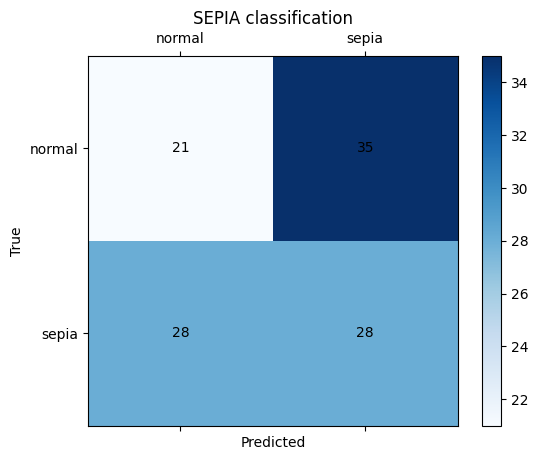

Accuracy: 0.4375
Precision per class: {'normal': np.float64(0.42857142857142855), 'sepia': np.float64(0.4444444444444444)}
Recall per class: {'normal': np.float64(0.375), 'sepia': np.float64(0.5)}


In [54]:
acc, prec, rec, cm = evalMultiClass(testOutputs, predictedLabels, outputNames)
plotConfusionMatrix(cm, outputNames, "SEPIA classification")
print("Accuracy:", acc)
print("Precision per class:", prec)
print("Recall per class:", rec)